In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import linregress as LR
import pandas as pd
from pandas.util.testing import assert_frame_equal
from sklearn.model_selection import train_test_split
pd.set_option("display.max_columns",200)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from subprocess import call

import xgboost as xgb

from sklearn.utils import resample
from sklearn.metrics import recall_score

In [2]:
#make a chronic patient table for this subset of conditions

# read in that pre-made table
df=pd.read_csv("../data_files/chronic_patients.csv")
df = df.dropna(axis = 0,how='any')
upsample=False

In [3]:
X = df[['VMONTH', 'AGE', 'SEX', 'RACE', 'ETHNIC', 'RFV1', 'DIAG1', 'DIAG2',
              'DIAG3', 'DIAG4', 'DIAG5', 'PAYTYPE','YEAR','PATWT', 'chronic','pain']]
y = df[['received']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

train = pd.concat([X_train, y_train], axis=1, sort=False)

In [4]:
#upsample the opiate-receivers
df_maj = train[train.received==0]
df_min = train[train.received==1]

if upsample:
    df_minority_upsampled = resample(df_min, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_maj))    # to match majority class
                                     #random_state=123) # reproducible results
    # Combine majority class with upsampled minority class
    train = pd.concat([df_maj, df_minority_upsampled])
else: #downsample
    df_majority_downsampled = resample(df_maj, 
                                     replace=False,     # sample with replacement
                                     n_samples=len(df_min))    # to match majority class
                                     #random_state=123) # reproducible results
    # Combine minority class with downsampled majority class
    train = pd.concat([df_majority_downsampled, df_min])

 
# Display new class counts
train.received.value_counts()

1    13555
0    13555
Name: received, dtype: int64

In [5]:
# upsample the pain-diagnosed
df_maj = train[train.pain==0]
df_min = train[train.pain==1]
df_minority_upsampled = resample(df_min, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_maj),    # to match majority class
                                 random_state=123) # reproducible results
# Combine majority class with upsampled minority class
train = pd.concat([df_maj, df_minority_upsampled])
 
# Display new class counts
train.pain.value_counts()

1    23804
0    23804
Name: pain, dtype: int64

In [6]:
X_train = train[['VMONTH', 'AGE', 'SEX', 'RACE', 'ETHNIC', 'RFV1', 'DIAG1', 'DIAG2',
              'DIAG3', 'DIAG4', 'DIAG5', 'PAYTYPE','YEAR','PATWT', 'chronic','pain']]
y_train = train[['received']]

In [7]:
model = xgb.XGBClassifier()#learning_rate=0.01)

In [8]:
model.fit(X_train[['VMONTH', 'AGE', 'SEX', 'RACE', 'ETHNIC', 'RFV1', 'DIAG1', 'DIAG2',
              'DIAG3', 'DIAG4', 'DIAG5', 'PAYTYPE','YEAR', 'chronic','pain']], y_train[['received']],sample_weight=X_train.PATWT.ravel())

/home/crkellar@byu.local/.local/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/crkellar@byu.local/.local/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [9]:
y_predict = model.predict(X_test[['VMONTH', 'AGE', 'SEX', 'RACE', 'ETHNIC', 'RFV1', 'DIAG1', 'DIAG2',
              'DIAG3', 'DIAG4', 'DIAG5', 'PAYTYPE','YEAR', 'chronic','pain']])#,sample_weight=X_wt2.PATWT.ravel())

In [10]:
accuracy_score(y_test, y_predict,sample_weight=X_test.PATWT.ravel())

0.7368532504899137

In [11]:
pd.DataFrame(
    confusion_matrix(y_test[['received']], y_predict),
    columns=['Predicted Not Received', 'Predicted Received'],
    index=['True Not Received', 'True Received']
)

,Predicted Not Received,Predicted Received
True Not Received,83318,30396
True Received,1365,3104


In [12]:
recall_score(y_test, y_predict)

0.6945625419556948

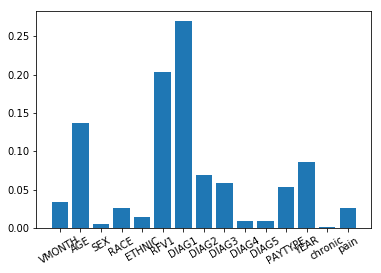

In [13]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(list(range(15)),['VMONTH', 'AGE', 'SEX', 'RACE', 'ETHNIC', 'RFV1', 'DIAG1', 'DIAG2',
              'DIAG3', 'DIAG4', 'DIAG5', 'PAYTYPE','YEAR', 'chronic','pain'], rotation=30)
plt.show()